In [31]:
import numpy as np
import json
import tensorflow.keras as keras

In [32]:
DATA_PATH = 'data.json'

with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

# Loading data from extracted json file
chroma = data["chroma_vector"]
labels = data["labels"]

# Padding data to reshape data into identical shapes
max_length = max(len(arr) for arr in chroma)
chroma = [
    np.pad(
        arr,
        pad_width=((0, max_length - len(arr)), (0, 0)),  
        mode='constant',
        constant_values=0
    )
    for arr in chroma
]

chroma = np.array(chroma)
labels = np.array(labels)

print(chroma.shape)
print(labels.shape)

(1996, 290, 12)
(1996,)


In [33]:
from sklearn.model_selection import train_test_split

def split_data(features, labels):
  """
  split_data(features, labels) splits the input data (features, labels) into training
  set, validation set, and testing set split as 60-10-30 i.e. 60% of the input data
  makes up the training set, 10% makes up the validation set, and 30% makes up the
  testing set.
  """
  
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
  return X_train, X_test, X_val, y_train, y_test, y_val

In [34]:
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(chroma, labels)

# Adding extra dimension to data for increased stability
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

print(chroma.shape)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(1996, 290, 12)
(290, 12, 1)


In [51]:
model = keras.Sequential()

# First Convolution Layer
model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
model.add(keras.layers.BatchNormalization())

# Second Convolution Layer
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
model.add(keras.layers.BatchNormalization())

# Third Convolution Layer
model.add(keras.layers.Conv2D(128, (2, 2), activation = 'relu', input_shape = input_shape))
model.add(keras.layers.MaxPool2D((2, 2), strides = (2, 2), padding = 'same'))
model.add(keras.layers.BatchNormalization())

# Converting the neurons into a 1D layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))

# Condensing neuron layer into 10 nodes, each corresponding to a chord label
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [52]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 288, 10, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 144, 5, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 144, 5, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 142, 3, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 71, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 71, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 70, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 35, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 35, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       286,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,042 (1.30 MB)

 Trainable params: 339,594 (1.30 MB)

 Non-trainable params: 448 (1.75 KB)

In [53]:
base_history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1785 - loss: 2.5999 - val_accuracy: 0.1190 - val_loss: 2.2803
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4917 - loss: 1.4409 - val_accuracy: 0.1190 - val_loss: 2.2759
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6621 - loss: 0.9901 - val_accuracy: 0.1190 - val_loss: 2.2853
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7829 - loss: 0.6914 - val_accuracy: 0.1952 - val_loss: 2.2782
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8247 - loss: 0.5331 - val_accuracy: 0.1381 - val_loss: 2.2974
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8803 - loss: 0.4007 - val_accuracy: 0.1333 - val_loss: 2.2955
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9129 - loss: 0.3185 - val_accuracy: 0.1619 - val_loss: 2.2401
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9045 - loss: 0.2786 - val_accuracy: 0.1857 - v

In [56]:
_, accuracy = model.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9337 - loss: 0.1917
Model accuracy: 92.654%.


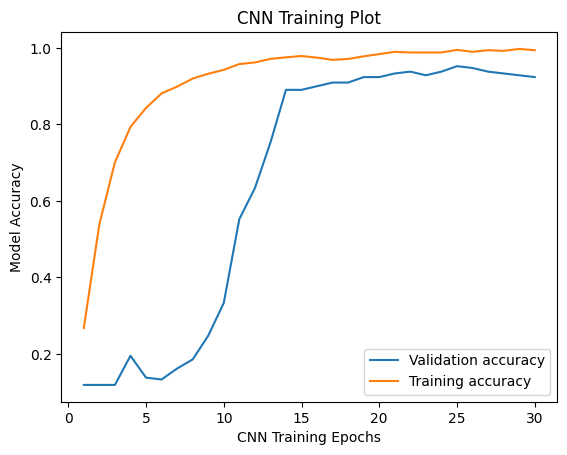

In [57]:
import matplotlib.pyplot as plt

x_range = range(1, 31)
plt.plot(x_range, base_history.history['val_accuracy'], label = 'Validation accuracy')
plt.plot(x_range, base_history.history['accuracy'], label = 'Training accuracy')
plt.xlabel('CNN Training Epochs')
plt.ylabel('Model Accuracy')
plt.title('CNN Training Plot')
plt.legend()
plt.show()